### step1:data preprocess-->wite the related table of json and image to txt file

In [1]:
with open('./file-list/json-list.txt','r') as f:
    arr=f.readlines()
    # arr=[i.strip() for i in arr]
    # images-arr=[i.lstrip('/json/').strip().rstrip('.json').strip() for i in arr]
arr=[i.replace('\n','')+" "+i.replace('/json/','/images/').replace('.json','.png') for i in arr]
str=','.join(arr).replace(',','')
f=open('./file-list/train-list.txt','w')
f.write(str)
f.close()



### step2:image preprocess-->水平翻转、垂直翻转、90°旋转、180°旋转、明暗度变化、对比度变化、饱和度变化、高斯噪声、随机切片（box>20px）、长宽比变化

In [2]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import json
import matplotlib
plt.rc('font',family='Times New Roman')
# del matplotlib.font_manager.weight_dict['roman']
# matplotlib.font_manager._rebuild()

def get_json_and_image_path(file_path):
    with open(file_path,'r') as f:
        arr=f.readlines()
    arr=[i.strip().split(' ') for i in arr]
    return arr

def get_bndboxes_and_image(json_and_image_path):
    json_path=json_and_image_path[0]
    image_path=json_and_image_path[1]
    bndboxes=[]
    label_names=[]
    with open(json_path,'r',encoding='utf-8') as f:
        json_data=json.load(f)
        # with 会自动close文件https://blog.csdn.net/u011280778/article/details/104283319?utm_medium=distribute.pc_relevant_t0.none-task-blog-BlogCommendFromMachineLearnPai2-1.channel_param&depth_1-utm_source=distribute.pc_relevant_t0.none-task-blog-BlogCommendFromMachineLearnPai2-1.channel_param
        # f.close()
    objects=json_data['outputs']['object']
    for obj in objects:
        bndboxes.append(obj['bndbox'])
        label_names.append(obj['name'])
    return bndboxes,label_names,cv2.imread(image_path)

if __name__=='__main__':
    train_list_path='./file-list/train-list.txt'
    arr=get_json_and_image_path(train_list_path)
    # for i in arr:
    #     print("json_path:"+i[0]+" image_path:"+i[1])
    bndboxes,label_names,image=get_bndboxes_and_image(arr[100])
    # print(image)
    for box in bndboxes:
        cv2.rectangle(image,(box['xmin'],box['ymin']),(box['xmax'],box['ymax']),(0,255,0),1)
    #     print("xmin:"+str(box['xmin'])+" ymin:"+str(box['ymin'])+ " xmax:"+str(box['xmax'])+" ymax:"+str(box['ymax'])+"\n")
    # cv2.imshow(label_names[0],image)
    # cv2.waitKey(0)
    plt.figure(figsize=(18,18))
    plt.imshow(image)
    plt.title(label_names[0],fontdict={'weight':'normal','size':18})
    # plt.savefig(fname="sample-data-show.svg",format="svg")
    plt.show()

TypeError: Image data of dtype object cannot be converted to float

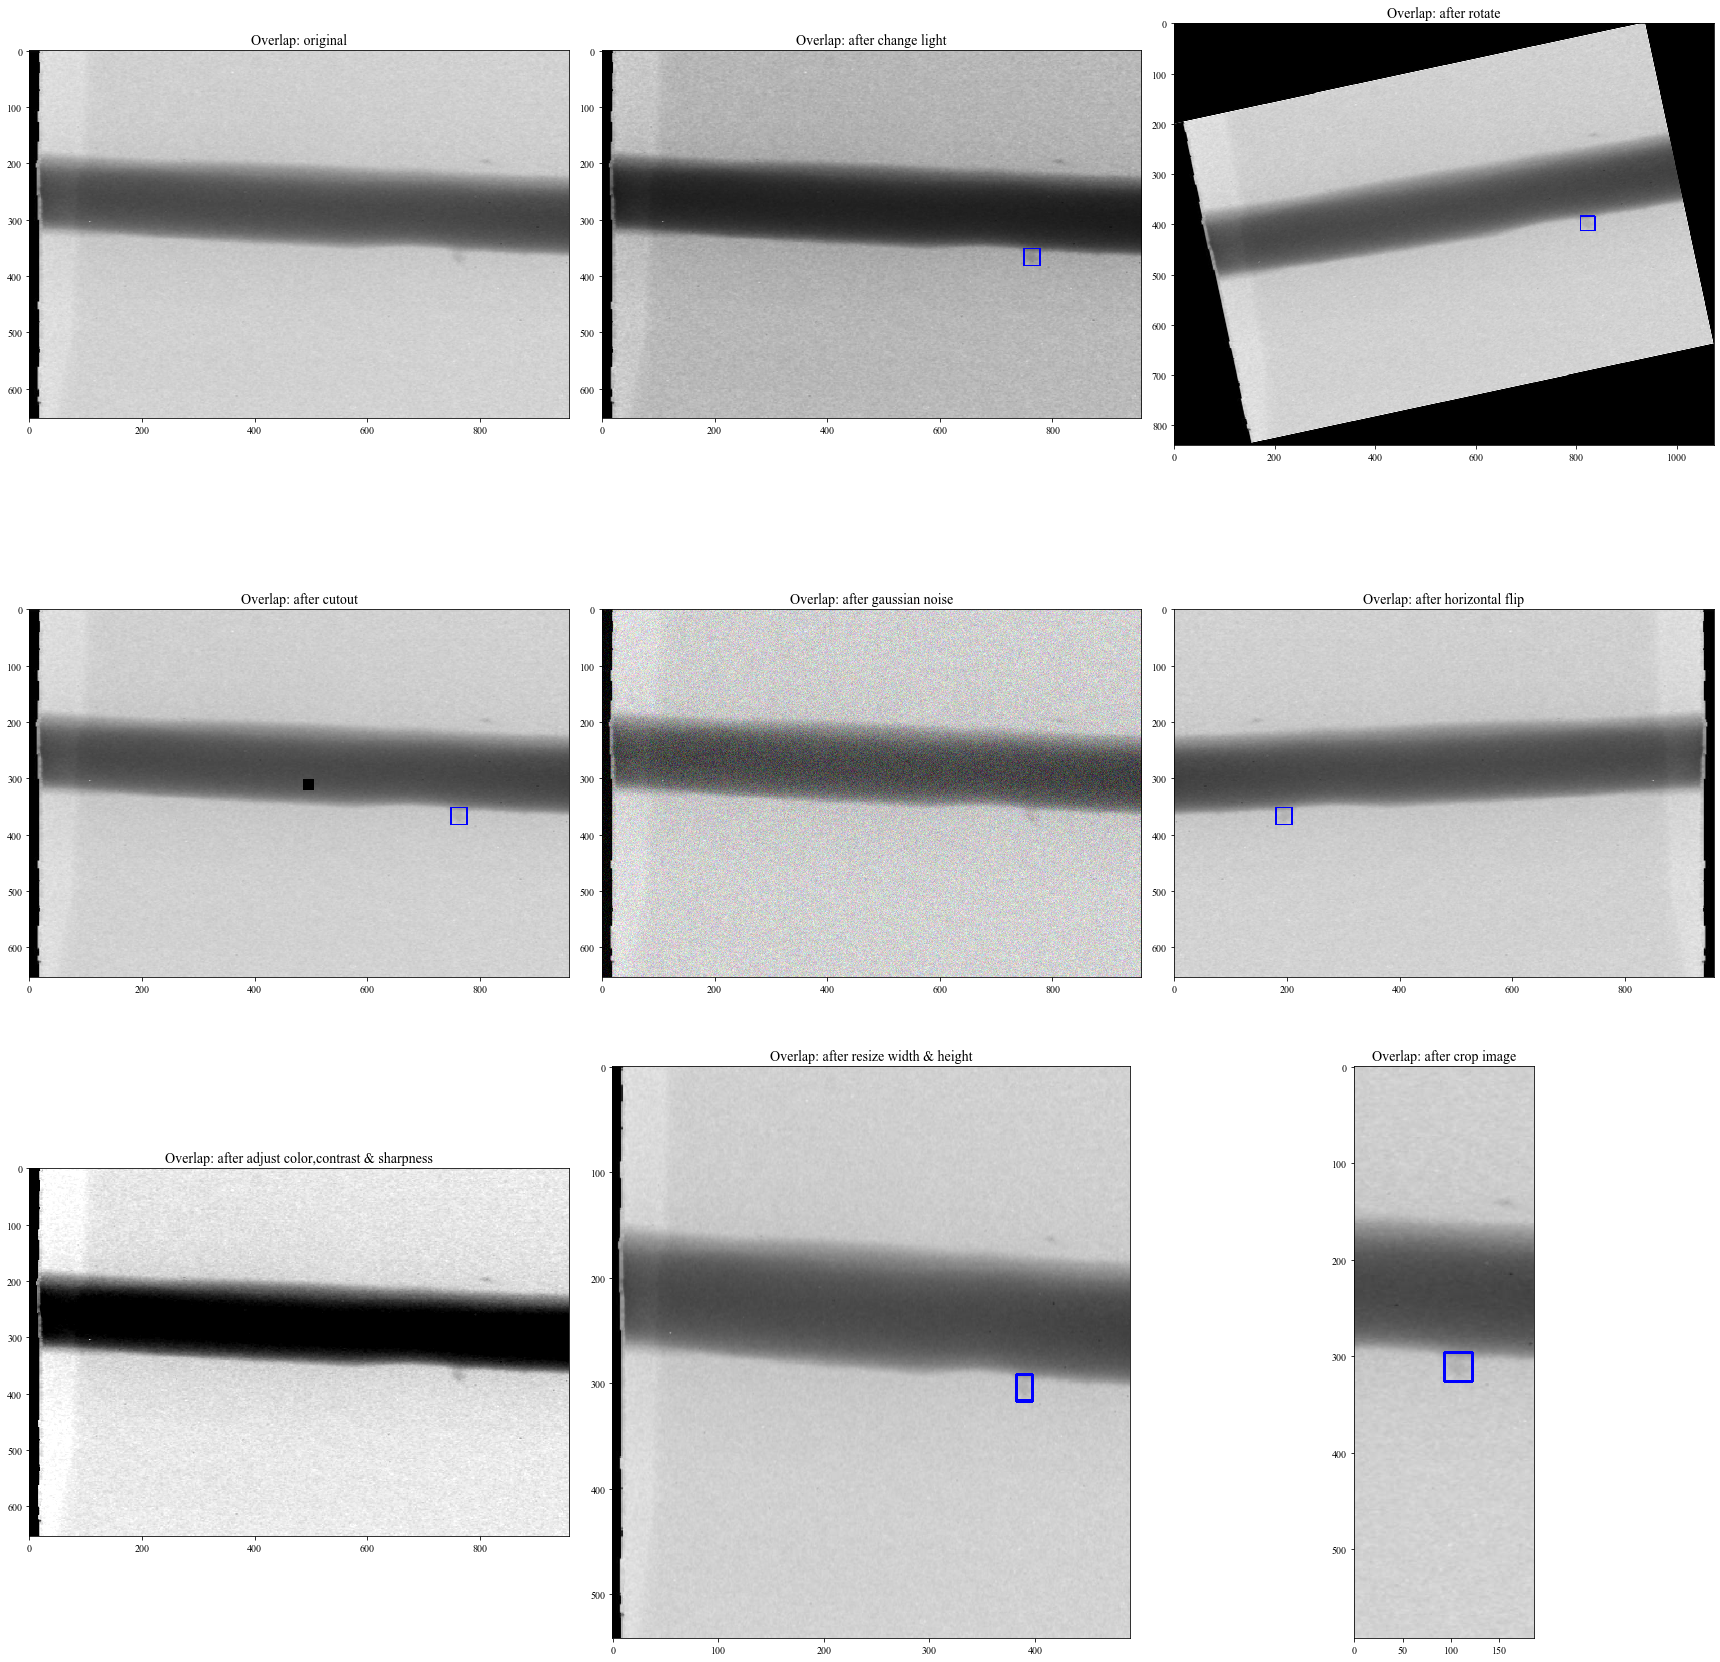

In [14]:
import random
from skimage import exposure
import numpy as np
import math
import skimage
from skimage import io
from PIL import Image,ImageEnhance,ImageOps,ImageFile,ImageChops
import copy

def change_light(image,bndboxes):
    # todo:可以加一个步长使明暗变化更明显
    flag=random.uniform(0.4,2.5)
    while(flag==1):
        flag=random.uniform(0.4,2.5)
    image=exposure.adjust_gamma(image,flag)
    for box in bndboxes:
        cv2.rectangle(image,(box['xmin'],box['ymin']),(box['xmax'],box['ymax']),(0,0,255),2)
    return image

def rotate(image,bndboxes,angle=5,scale=1.):
    w=image.shape[1]
    h=image.shape[0]

    rangle=np.deg2rad(angle)
    nw=(abs(np.sin(rangle)*h)+abs(np.cos(rangle)*w))*scale
    nh=(abs(np.cos(rangle)*h)+abs(np.sin(rangle)*w))*scale

    rot_mat=cv2.getRotationMatrix2D((nw*.5,nh*.5),angle,scale)
    rot_move=np.dot(rot_mat,np.array([(nw-w)*.5,(nh-h)*.5,0]))
    rot_mat[0,2]+=rot_move[0]
    rot_mat[1,2]+=rot_move[1]

    rot_img=cv2.warpAffine(image,rot_mat,(int(math.ceil(nw)),int(math.ceil(nh))),flags=cv2.INTER_LANCZOS4)

    rot_boxes=list()
    for box in bndboxes:
        p1=np.dot(rot_mat,np.array([(box['xmin']+box['xmax'])/2,box['ymin'],1]))
        p2=np.dot(rot_mat,np.array([box['xmax'],(box['ymin']+box['ymax'])/2,1]))
        p3=np.dot(rot_mat,np.array([(box['xmin']+box['xmax'])/2,box['ymax'],1]))
        p4=np.dot(rot_mat,np.array([box['xmin'],(box['ymin']+box['ymax'])/2,1]))
        concat=np.vstack((p1,p2,p3,p4))
        concat=concat.astype(np.int32)
        rx,ry,rw,rh=cv2.boundingRect(concat)
        rx_min=rx
        ry_min=ry
        rx_max=rx+rw
        ry_max=ry+rw
        rot_boxes.append({'xmin':rx_min,'ymin':ry_min,'xmax':rx_max,'ymax':ry_max})

    for box in rot_boxes:
        cv2.rectangle(rot_img,(box['xmin'],box['ymin']),(box['xmax'],box['ymax']),(0,0,255),2)
    return rot_img

# todo:fix the bug of zero after mask operation;adjust the position of hole
def cutout(image,bndboxes,length=20,hole_num=1,threshold=.5):
    if image.ndim==3:
        h,w,c=image.shape
    else:
        _,h,w,c=image.shape
    mask=np.ones((h,w,c),np.int32)
    for i in range(hole_num):
        y=np.random.randint(h)
        x=np.random.randint(w)
        y1=np.clip(y-length//2,0,h)
        y2=np.clip(y+length//2,0,h)
        x1=np.clip(x-length//2,0,w)
        x2=np.clip(x+length//2,0,w)

        mask[y1:y2,x1:x2]=0
    # mask = np.expand_dims(mask, axis=0)
    # mask = torch.from_numpy(mask)
    # mask=mask.expand_as(image)
    # print(type(image[0][0]))
    image=image*mask
    # for i in range(y1,y2):
    #     for j in range(x1,x2):
    #         print(str(image[i][j])+' ')
    #     print('\n')
    for box in bndboxes:
        cv2.rectangle(image,(box['xmin'],box['ymin']),(box['xmax'],box['ymax']),(0,0,255),2)
    return image

# !!!!the reture image format is skimage package
def gaussian_noise(image):
    return skimage.util.random_noise(image,mode='gaussian',var=.004)

def flip(image,bndboxes):
    h=image.shape[0]
    w=image.shape[1]
    image=cv2.warpAffine(image,cv2.getRotationMatrix2D((w*.5,h*.5),0,1),(w,h))
    # 1水平翻转；2垂直翻转
    image=cv2.flip(image,1)
    for box in bndboxes:
        box['xmin']=w-1-box['xmin']
        box['xmax']=w-1-box['xmax']
        cv2.rectangle(image,(box['xmin'],box['ymin']),(box['xmax'],box['ymax']),(0,0,255),2)
    return image

# !!!!the return format of iamge is Image in PIL package
def color(image):
    image=Image.fromarray(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    # 饱和度
    ran=np.random.randint(0, 31) / 10.
    image=ImageEnhance.Color(image).enhance(ran)
    # 对比度
    ran=np.random.randint(10, 21) / 10.
    image=ImageEnhance.Contrast(image).enhance(ran)
    # 锐度
    ran=np.random.randint(0, 31) / 10.
    image=ImageEnhance.Sharpness(image).enhance(ran)
    return image

# def shift(image,bndboxes):
#     h=image.shape[0]
#     w=image.shape[1]
#     offset_x=np.random.randint(-math.ceil(w*.2),math.ceil(w*.2))
#     offset_y=np.random.randint(-math.ceil(h*.2),math.ceil(h*.2))
#     for box in bndboxes:
#         box['xmin']+=offset_x
#         box['xmax']+=offset_x
#         box['ymin']+=offset_y
#         box['ymax']+=offset_y
#         cv2.rectangle(image,(box['xmin'],box['ymin']),(box['xmax'],box['ymax']),(0,255,0),2)
#     image2=Image.fromarray(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
#     return ImageChops.offset(image2,offset_x,offset_y)

def resize(image,bndboxes):
    h=image.shape[0]
    w=image.shape[1]
    ran_h=np.random.randint(h*.5,h)
    ran_w=np.random.randint(w*.5,w)
    image=cv2.resize(image,(ran_w,ran_h),interpolation=cv2.INTER_LINEAR)
    for box in bndboxes:
        box['xmin']=int((ran_w/w)*box['xmin'])
        box['xmax']=int((ran_w/w)*box['xmax'])
        box['ymin']=int(box['ymin']*(ran_h/h))
        box['ymax']=int(box['ymax']*(ran_h/h))
        cv2.rectangle(image,(box['xmin'],box['ymin']),(box['xmax'],box['ymax']),(0,0,255),2)
    return image

def crop(image,bndboxes):
    w=image.shape[1]
    h=image.shape[0]
    xmin=w
    xmax=0
    ymin=h
    ymax=0
    for box in bndboxes:
        xmin=min(xmin,box['xmin'])
        xmax=max(xmax,box['xmax'])
        ymin=min(ymin,box['ymin'])
        ymax=max(ymax,box['ymax'])
    crop_left=random.randint(0,xmin)
    crop_right=random.randint(xmax,w)
    crop_top=random.randint(0,ymin)
    crop_bottom=random.randint(ymax,h)
    crop_image=image[crop_top:crop_bottom,crop_left:crop_right]
    for box in bndboxes:
        box['xmin']-=crop_left
        box['xmax']-=crop_left
        box['ymin']-=crop_top
        box['ymax']-=crop_top
        cv2.rectangle(crop_image,(box['xmin'],box['ymin']),(box['xmax'],box['ymax']),(0,0,255),2)
    return crop_image



if __name__=='__main__':
    train_list_path='./file-list/train-list.txt'
    arr=get_json_and_image_path(train_list_path)
    # for i in arr:
    #     print("json_path:"+i[0]+" image_path:"+i[1])

    plt.figure(figsize=(24,24))

    bndboxes,label_names,image=get_bndboxes_and_image(arr[700])
    label_names=['Blowhole','Undercut','Broken arc','Crack','Overlap','Slag inclusion','Lack of fusion']

    plt.subplot(331)
    plt.title(label_names[4]+": original",fontdict={'weight':'normal','size':14})
    plt.imshow(image)

    image2=change_light(image,bndboxes)
    plt.subplot(332)
    plt.title(label_names[4]+": after change light",fontdict={'weight':'normal','size':14})
    plt.imshow(image2)

    image3=rotate(image=copy.deepcopy(image),bndboxes=copy.deepcopy(bndboxes),angle=random.uniform(-15,15))
    plt.subplot(333)
    plt.title(label_names[4]+": after rotate",fontdict={'weight':'normal','size':14})
    plt.imshow(image3)

    image4=cutout(image=image,bndboxes=bndboxes)
    plt.subplot(334)
    plt.title(label_names[4]+": after cutout",fontdict={'weight':'normal','size':14})
    plt.imshow(image4)

    image5=gaussian_noise(image)
    plt.subplot(335)
    plt.title(label_names[4]+": after gaussian noise",fontdict={'weight':'normal','size':14})
    plt.imshow(image5)

    # 数组在python中是引用传递所以要用deepcopy拷贝一个新对象
    image6=flip(copy.deepcopy(image),copy.deepcopy(bndboxes))
    plt.subplot(336)
    plt.title(label_names[4]+": after horizontal flip",fontdict={'weight':'normal','size':14})
    plt.imshow(image6)

    image7=color(image)
    plt.subplot(337)
    plt.title(label_names[4]+": after adjust color,contrast & sharpness",fontdict={'weight':'normal','size':14})
    plt.imshow(image7)

    # image8=shift(image,bndboxes)
    # plt.subplot(335)
    # plt.title(label_names[0]+"：随机平移后",fontdict={'weight':'normal','size':14})
    # plt.imshow(image8)

    image9=resize(copy.deepcopy(image),copy.deepcopy(bndboxes))
    plt.subplot(338)
    plt.title(label_names[4]+": after resize width & height",fontdict={'weight':'normal','size':14})
    plt.imshow(image9)

    image10=crop(copy.deepcopy(image),copy.deepcopy(bndboxes))
    plt.subplot(339)
    plt.title(label_names[4]+": after crop image",fontdict={'weight':'normal','size':14})
    plt.imshow(image10)
    # plt.savefig(fname="data-augmentation-en.svg",format="svg") 
    plt.tight_layout()
    plt.show()
    # cv2.imwrite('./test/image.jpg',image)
    # cv2.imwrite('./test/image2.jpg',image2)
    # cv2.imwrite('./test/image3.jpg',image3)
    # cv2.imwrite('./test/image4.jpg',image4)
    # io.imsave('./test/image5.jpg',image5)
    # cv2.imwrite('./test/image6.jpg',image6)
    # image7.save('./test/image7.jpg')
    # # cv2.imwrite('./test/image7.jpg',image77)
    # cv2.imwrite('./test/image9.jpg',image9)
    cv2.imwrite('./test/image10.jpg',image10)

In [6]:
from PIL import Image

def get_json_data(json_file_path):
    data={}
    with open(json_file_path,'r',encoding='utf-8') as f:
        data=json.load(f)
    return data
def write_json_data(json_file_path,json_data):
    with open(json_file_path,'w',encoding='utf-8') as f:
        json.dump(json_data,f,ensure_ascii=False)

# if __name__=='__main__':
#     label_name_dict={
#         '气孔':'air-hole',
#         '咬边':'bite-edge',
#         '断弧':'broken-arc',
#         '裂纹':'crack',
#         '焊瘤':'overlap',
#         '夹渣':'slag-inclusion',
#         '未熔合':'unfused'
#     }
#     # items=label_name_dict.items()
#     # print(items)
#     train_list_path='./file-list/train-list.txt'
#     arr=get_json_and_image_path(train_list_path)
#     for row in arr:
#         image=Image.open(row[1])
#         rgb_image=image.convert('RGB')
#         rgb_image.save(row[1].replace('.png','.jpg'))

#         data=get_json_data(row[0])
#         data['path']=data['path'].replace('E:\\Yangdingming\\Documents\\output-images3\\','./images/').replace('.png','.jpg')
#         arr=data['outputs']['object']
#         for i in range(len(arr)):
#             # 'dict' object has no attribute 'has_key'
#             if arr[i]['name'] in label_name_dict:
#                 data['outputs']['object'][i]['name']=label_name_dict[arr[i]['name']]
#         write_json_data(row[0],data)

#     arr=[]
#     with open(train_list_path,'r') as f:
#         arr=f.readlines()
#     arr=[i.replace('.png','.jpg') for i in arr]
#     # str是python自带关键字
#     s=','.join(arr).replace(',','')
#     with open(train_list_path,'w') as f:
#         f.write(s)


In [7]:
import re
def change_light(image,bndboxes):
    flag=random.uniform(0.4,2.5)
    while(flag==1):
        flag=random.uniform(0.4,2.5)
    return exposure.adjust_gamma(image,flag)

def rotate(image,bndboxes,angle=5,scale=1.):
    w=image.shape[1]
    h=image.shape[0]

    rangle=np.deg2rad(angle)
    nw=(abs(np.sin(rangle)*h)+abs(np.cos(rangle)*w))*scale
    nh=(abs(np.cos(rangle)*h)+abs(np.sin(rangle)*w))*scale

    rot_mat=cv2.getRotationMatrix2D((nw*.5,nh*.5),angle,scale)
    rot_move=np.dot(rot_mat,np.array([(nw-w)*.5,(nh-h)*.5,0]))
    rot_mat[0,2]+=rot_move[0]
    rot_mat[1,2]+=rot_move[1]

    rot_img=cv2.warpAffine(image,rot_mat,(int(math.ceil(nw)),int(math.ceil(nh))),flags=cv2.INTER_LANCZOS4)

    rot_boxes=list()
    for box in bndboxes:
        p1=np.dot(rot_mat,np.array([(box['xmin']+box['xmax'])/2,box['ymin'],1]))
        p2=np.dot(rot_mat,np.array([box['xmax'],(box['ymin']+box['ymax'])/2,1]))
        p3=np.dot(rot_mat,np.array([(box['xmin']+box['xmax'])/2,box['ymax'],1]))
        p4=np.dot(rot_mat,np.array([box['xmin'],(box['ymin']+box['ymax'])/2,1]))
        concat=np.vstack((p1,p2,p3,p4))
        concat=concat.astype(np.int32)
        rx,ry,rw,rh=cv2.boundingRect(concat)
        rx_min=rx
        ry_min=ry
        rx_max=rx+rw
        ry_max=ry+rw
        rot_boxes.append({'xmin':rx_min,'ymin':ry_min,'xmax':rx_max,'ymax':ry_max})
    return rot_img,rot_boxes,nw,nh

def cutout(image,bndboxes,length=20,hole_num=1,threshold=.5):
    if image.ndim==3:
        h,w,c=image.shape
    else:
        _,h,w,c=image.shape
    mask=np.ones((h,w,c),np.int32)
    for i in range(hole_num):
        y=np.random.randint(h)
        x=np.random.randint(w)
        y1=np.clip(y-length//2,0,h)
        y2=np.clip(y+length//2,0,h)
        x1=np.clip(x-length//2,0,w)
        x2=np.clip(x+length//2,0,w)
        mask[y1:y2,x1:x2]=0
    return image*mask

def gaussian_noise(image):
    return skimage.util.random_noise(image,mode='gaussian',var=.004)

def flip(image,bndboxes):
    h=image.shape[0]
    w=image.shape[1]
    image=cv2.warpAffine(image,cv2.getRotationMatrix2D((w*.5,h*.5),0,1),(w,h))
    # 1水平翻转；2垂直翻转
    image=cv2.flip(image,1)
    for box in bndboxes:
        box['xmin']=w-1-box['xmin']
        box['xmax']=w-1-box['xmax']
        cv2.rectangle(image,(box['xmin'],box['ymin']),(box['xmax'],box['ymax']),(0,255,0),2)
    return image,bndboxes

def resize(image,bndboxes):
    h=image.shape[0]
    w=image.shape[1]
    ran_h=np.random.randint(h*.5,h)
    ran_w=np.random.randint(w*.5,w)
    image=cv2.resize(image,(ran_w,ran_h),interpolation=cv2.INTER_LINEAR)
    for box in bndboxes:
        box['xmin']=int((ran_w/w)*box['xmin'])
        box['xmax']=int((ran_w/w)*box['xmax'])
        box['ymin']=int(box['ymin']*(ran_h/h))
        box['ymax']=int(box['ymax']*(ran_h/h))
    return image,bndboxes,ran_w,ran_h

def crop(image,bndboxes):
    w=image.shape[1]
    h=image.shape[0]
    xmin=w
    xmax=0
    ymin=h
    ymax=0
    for box in bndboxes:
        xmin=min(xmin,box['xmin'])
        xmax=max(xmax,box['xmax'])
        ymin=min(ymin,box['ymin'])
        ymax=max(ymax,box['ymax'])
    crop_left=random.randint(0,xmin)
    crop_right=random.randint(xmax,w)
    crop_top=random.randint(0,ymin)
    crop_bottom=random.randint(ymax,h)
    crop_image=image[crop_top:crop_bottom,crop_left:crop_right]
    for box in bndboxes:
        box['xmin']-=crop_left
        box['xmax']-=crop_left
        box['ymin']-=crop_top
        box['ymax']-=crop_top
    return crop_image,bndboxes,crop_right-crop_left,crop_bottom-crop_top
# todo:judge the text is writed successful
def append_json_and_image_path(file_path,text):
     with open(file_path, 'a', encoding='utf-8') as file:
        file.write('\n'+text)

def insert_before_num(input_str,ins_str):
    return re.sub(r'\d',ins_str+re.search( r'\d', input_str, re.M|re.I).group(0),input_str,count=1)

if __name__=='__main__':
    train_list_path='./file-list/train-list.txt'
    arr=get_json_and_image_path(train_list_path)
    count=0
    loop_count=0
    for row in arr:
        bndboxes,label_names,image=get_bndboxes_and_image(row)

        image2=change_light(image,bndboxes)
        light_image_path=insert_before_num(row[1],'(light)')
        cv2.imwrite(light_image_path,image2)
        json_obj2=get_json_data(row[0])
        json_obj2['path']=light_image_path
        write_json_data(insert_before_num(row[0],'(light)'),json_obj2)
        append_json_and_image_path(train_list_path,row[0]+' '+light_image_path)
        count+=1
        print(str(count)+light_image_path+' completed!')

        image3,bndboxes3,nw3,nh3=rotate(image=copy.deepcopy(image),bndboxes=copy.deepcopy(bndboxes),angle=random.uniform(-45,45))
        rotate_image_path=insert_before_num(row[1],'(rotate)')
        cv2.imwrite(rotate_image_path,image3)
        # write json file
        obj3=[]
        for i in range(len(bndboxes3)):
            obj3.append({"name":label_names[i],"bndbox":bndboxes3[i]})
        json_obj3={
            "path": rotate_image_path,
            "outputs": {
                "object": obj3
            },
            "time_labeled": 0,
            "labeled": True,
            "size": {
                "width": nw3,
                "height": nh3,
                "depth": 3
            }
        }
        rotate_json_path=insert_before_num(row[0],'(rotate)')
        with open(rotate_json_path,'w',encoding='utf-8') as f:
            json.dump(json_obj3,f,ensure_ascii=False)
        append_json_and_image_path(train_list_path,rotate_json_path+' '+rotate_image_path)
        count+=1
        print(str(count)+rotate_image_path+' completed!')

        image4=cutout(image=image,bndboxes=bndboxes)
        cutout_image_path=insert_before_num(row[1],'(cutout)')
        cv2.imwrite(cutout_image_path,image4)
        json_obj4=get_json_data(row[0])
        json_obj4['path']=cutout_image_path
        write_json_data(insert_before_num(row[0],'(cutout)'),json_obj4)
        append_json_and_image_path(train_list_path,row[0]+' '+cutout_image_path)
        count+=1
        print(str(count)+cutout_image_path+' completed!')

        image5=gaussian_noise(image)
        noise_image_path=insert_before_num(row[1],'(noise)')
        skimage.io.imsave(noise_image_path,image5)
        json_obj5=get_json_data(row[0])
        json_obj5['path']=noise_image_path
        write_json_data(insert_before_num(row[0],'(noise)'),json_obj5)
        append_json_and_image_path(train_list_path,row[0]+' '+noise_image_path)
        count+=1
        print(str(count)+noise_image_path+' completed!')

        image6,bndboxes6=flip(copy.deepcopy(image),copy.deepcopy(bndboxes))
        flip_image_path=insert_before_num(row[1],'(flip)')
        cv2.imwrite(flip_image_path,image6)

        obj6=[]
        for i in range(len(bndboxes6)):
            obj6.append({"name":label_names[i],"bndbox":bndboxes6[i]})
        json_obj6={
            "path": flip_image_path,
            "outputs": {
                "object": obj6
            },
            "time_labeled": 0,
            "labeled": True,
            "size": {
                "width": 958,
                "height": 653,
                "depth": 3
            }
        }
        flip_json_path=insert_before_num(row[0],'(flip)')
        with open(flip_json_path,'w',encoding='utf-8') as f:
            json.dump(json_obj6,f,ensure_ascii=False)
        append_json_and_image_path(train_list_path,flip_json_path+' '+flip_image_path)
        count+=1
        print(str(count)+flip_image_path+' completed!')

        image7=color(image)
        color_image_path=insert_before_num(row[1],'(color)')
        # PIL package
        image7.save(color_image_path)
        json_obj7=get_json_data(row[0])
        json_obj7['path']=noise_image_path
        write_json_data(insert_before_num(row[0],'(color)'),json_obj7)
        append_json_and_image_path(train_list_path,row[0]+' '+color_image_path)
        count+=1
        print(str(count)+color_image_path+' completed!')

        image9,bndboxes9,nw9,nh9=resize(copy.deepcopy(image),copy.deepcopy(bndboxes))
        resize_image_path=insert_before_num(row[1],'(resize)')
        cv2.imwrite(resize_image_path,image9)
        obj9=[]
        for i in range(len(bndboxes9)):
            obj9.append({"name":label_names[i],"bndbox":bndboxes9[i]})
        json_obj9={
            "path": resize_image_path,
            "outputs": {
                "object": obj9
            },
            "time_labeled": 0,
            "labeled": True,
            "size": {
                "width": nw9,
                "height": nh9,
                "depth": 3
            }
        }
        resize_json_path=insert_before_num(row[0],'(resize)')
        with open(resize_json_path,'w',encoding='utf-8') as f:
            json.dump(json_obj9,f,ensure_ascii=False)
        append_json_and_image_path(train_list_path,resize_json_path+' '+resize_image_path)
        count+=1
        print(str(count)+resize_image_path+' completed!')

        image10,bndboxes10,nw10,nh10=crop(copy.deepcopy(image),copy.deepcopy(bndboxes))
        crop_image_path=insert_before_num(row[1],'(crop)')
        cv2.imwrite(crop_image_path,image10)
        obj10=[]
        for i in range(len(bndboxes10)):
            obj10.append({"name":label_names[i],"bndbox":bndboxes10[i]})
        json_obj10={
            "path": crop_image_path,
            "outputs": {
                "object": obj10
            },
            "time_labeled": 0,
            "labeled": True,
            "size": {
                "width": nw10,
                "height": nh10,
                "depth": 3
            }
        }
        crop_json_path=insert_before_num(row[0],'(crop)')
        with open(crop_json_path,'w',encoding='utf-8') as f:
            json.dump(json_obj10,f,ensure_ascii=False)
        append_json_and_image_path(train_list_path,crop_json_path+' '+crop_image_path)
        count+=1
        print(str(count)+crop_image_path+' completed!')
        loop_count+=1
        print(str(loop_count)+'.task completed!')
    print('all data augmentation task completed!')


6173./images/unfused(flip)47.jpg completed!
6174./images/unfused(color)47.jpg completed!
6175./images/unfused(resize)47.jpg completed!
6176./images/unfused(crop)47.jpg completed!
772.task completed!
6177./images/unfused(light)48.jpg completed!
6178./images/unfused(rotate)48.jpg completed!
6179./images/unfused(cutout)48.jpg completed!
6180./images/unfused(noise)48.jpg completed!
6181./images/unfused(flip)48.jpg completed!
6182./images/unfused(color)48.jpg completed!
6183./images/unfused(resize)48.jpg completed!
6184./images/unfused(crop)48.jpg completed!
773.task completed!
6185./images/unfused(light)49.jpg completed!
6186./images/unfused(rotate)49.jpg completed!
6187./images/unfused(cutout)49.jpg completed!
6188./images/unfused(noise)49.jpg completed!
6189./images/unfused(flip)49.jpg completed!
6190./images/unfused(color)49.jpg completed!
6191./images/unfused(resize)49.jpg completed!
6192./images/unfused(crop)49.jpg completed!
774.task completed!
all data augmentation task completed!


### step3:样本数据分析(长宽比的分布，有没有极限长宽比)

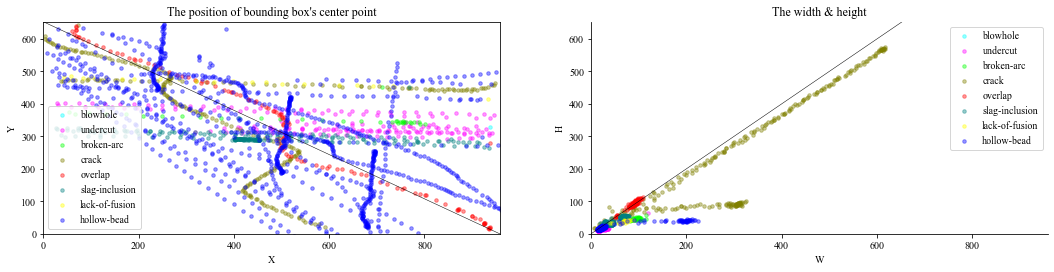

In [3]:
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.gridspec import SubplotSpec
import numpy as np

import matplotlib
from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',  # 设置字体类型
    # "font.size": 80,
#     "mathtext.fontset":'stix',
}
rcParams.update(config)

if __name__=='__main__':
    train_list_path='./file-list/train-all.txt'
    arr=get_json_and_image_path(train_list_path)

    fig=plt.figure(figsize=(18,18))
    gs = GridSpec(1, 2, figure=fig)

    # ax1 = fig.add_subplot(gs[1,0])
    # ax1.set_aspect(653/958)
    # plt.title('boundingbox的位置')
    # plt.xlim(0,958)
    # plt.ylim(0,653)
    # plt.xlabel('X')
    # plt.ylabel('Y')
    # j=-1
    labels=['blowhole','undercut','broken-arc','crack','overlap','slag-inclusion','lack-of-fusion','hollow-bead']
    # labels=['气孔','咬边','断弧','裂纹','焊瘤','夹渣','未融合']
    # colors=['#00CED1','#DC143C','#00582D','#D8FF00','#D200FF','#0048FF','#759A13','#FF0000']
    colors=['Aqua','Fuchsia','Lime','Olive','Red','Teal','Yellow','Blue']
    coords=[]
    w_list=[]
    h_list=[]

    coords_center=[]
    c_x_list=[]
    c_y_list=[]
    lable_set=set()
    # lable_set.add('气孔')
    # num=0
    for row in arr:
        bndboxes,label_names,image=get_bndboxes_and_image(row)
        for i in range(len(bndboxes)):
            # num+=len(bndboxes)
            w=bndboxes[i]['xmax']-bndboxes[i]['xmin']
            h=bndboxes[i]['ymax']-bndboxes[i]['ymin']
            w_list.append(w)
            h_list.append(h)

            c_x=(bndboxes[i]['xmax']+bndboxes[i]['xmin'])/2
            # plot坐标原点在左下角，原图是在左上角，所以要将y轴坐标上下翻转
            c_y=653-1-(bndboxes[i]['ymax']+bndboxes[i]['ymin'])/2
            c_x_list.append(c_x)
            c_y_list.append(c_y)
            if label_names[i] not in lable_set:
                lable_set.add(label_names[i])
                # print(label_names[i]+' '+str(i))
                # print(w_list)
                # print(label_names[i])
                # item_dict=dict()
                coords.append({"name":label_names[i],"w":w_list.copy(),"h":h_list.copy()})
                w_list.clear()
                h_list.clear()
                coords_center.append({"name":label_names[i],"x":c_x_list.copy(),"y":c_y_list.copy()})
                c_x_list.clear()
                c_y_list.clear()
                # j+=1
    #             # print(j)
    #         plt.gca().add_patch(plt.Rectangle(xy=(bndboxes[i]['xmin'],653-1-bndboxes[i]['ymin']),
    #                               width=w,
    #                               height=h,
    #                               edgecolor=colors[j],
    #                               fill=False, linewidth=1))
    #         # fig = plt.figure(figsize=(5,1.5))
    #         #设置字在图片中显示的位置,宽和高的百分比，距离图左上角顶点的距离
    #         # text = fig.text(bndboxes[i]['xmin'],bndboxes[i]['ymin'],labels[j],color=colors[j],ha="center",va="center",size=14)
    #         # text.set_path_effects([path_effects.Normal()])
    # # print(num)
    ax2 = fig.add_subplot(gs[0,1])
    ax2.set_aspect(653/958)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    plt.title('The width & height')
    plt.xlim(0,958)
    plt.ylim(0,653)
    plt.xlabel('W')
    plt.ylabel('H')
    # coords=np.array(coords)
    for i in range(len(coords)):
        # print(coords[i]['w'])
        # print(str(len(coords[i]['w']))+' '+str(len(coords[i]['h'])))
        plt.scatter(coords[i]['w'], coords[i]['h'], s=np.pi*2**2, c=colors[i], alpha=0.4, label=labels[i])
        # print(coords[i,:,0])
        # print(colors[i])
        # plt.plot(coords[i,:,0],coords[i,:,1],linewidth='0.5',color=colors[i])
    plt.plot([0,653],[0,653],linewidth = '0.5',color='#000000')
    # plt.plot(linewidth = '0.5',color='#000000')
    plt.legend()

    ax3 = fig.add_subplot(gs[0,0])
    ax3.set_aspect(653/958)
    plt.title("The position of bounding box's center point")
    plt.xlim(0,958)
    plt.ylim(0,653)
    plt.xlabel('X')
    plt.ylabel('Y')
    coords_center=np.array(coords_center)
    for i in range(len(coords_center)):
        plt.scatter(coords_center[i]['x'], coords_center[i]['y'], s=np.pi*2**2, c=colors[i], alpha=0.4, label=labels[i])
    plt.plot([0,958],[653,0],linewidth = '0.5',color='#000000')
    # plt.plot(linewidth = '0.5',color='#000000')
    plt.legend()

    # ax4=fig.add_subplot(gs[0,0])
    # # ax4.set_aspect(653/958)
    # ax4.spines['top'].set_visible(False)
    # ax4.spines['right'].set_visible(False)
    # nums = [81, 72, 250, 120, 219, 23, 50]
    # plt.barh(range(7), nums, height=0.5, color=colors, alpha=0.8)      # 从下往上画
    # plt.yticks(range(7), labels)
    # plt.xlabel("number")
    # plt.title("number of samples")
    # for x, y in enumerate(nums):
    #     plt.text(y + 0.2, x - 0.1, '%s' % y)
    # plt.tight_layout(pad=0.4,w_pad=0.5,h_pad=1.0)
    plt.savefig(fname="sample-data-analysis-v3-en.svg",format="svg")      
    plt.show()

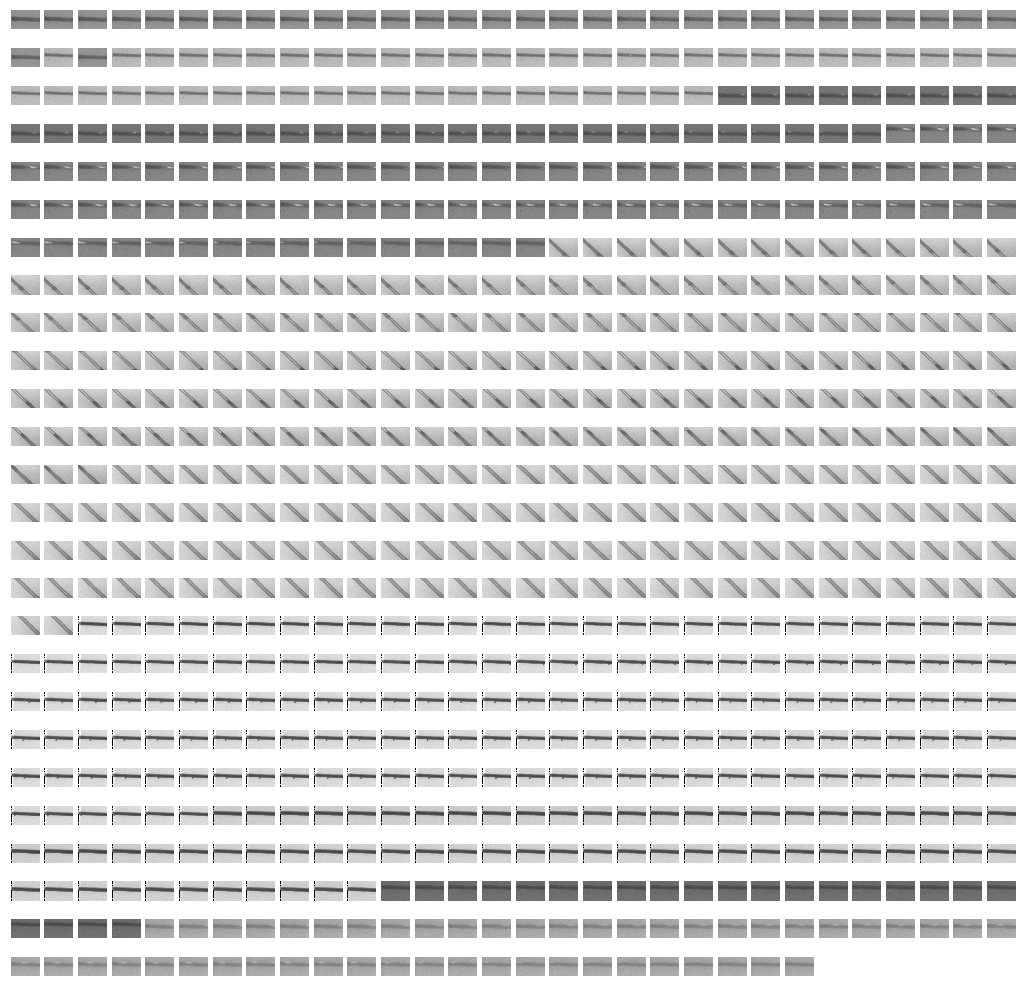

In [11]:
images=list()
for row in arr:
    bndboxes,label_names,image=get_bndboxes_and_image(row)
    images.append(image)
# plt.title('sample data show')
# fig.subplots_adjust(left=0.0,bottom=0.0,top=0.1,right=0.1)
fig=plt.figure(figsize=(18,18))
for i in range(len(images)):
    ax=plt.subplot(26,int(len(images)/26)+1,i+1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
# plt.subplots_adjust(wspace=0,hspace=0)
# plt.savefig(fname="samples-data-show.svg",format="svg")  
plt.show()

In [18]:
# images=list()
# for row in arr:
#     bndboxes,label_names,image=get_bndboxes_and_image(row)
#     images.append(image)
fig,axes=plt.subplots(26,int(len(images)/26)+1,sharex=True,sharey=True)
fig=plt.figure(figsize=(18,18))
k=0
for i in range(26):
    for j in range(int(len(images)/26)+1):
        axes[i][j].spines['top'].set_visible(False)
        axes[i][j].spines['right'].set_visible(False)
        axes[i][j].spines['bottom'].set_visible(False)
        axes[i][j].spines['left'].set_visible(False)
        axes[i][j].imshow(images[k])
        axes[i][j].xticks([])
        axes[i][j].yticks([])
        k+=1
        if(k==len(images)):
            break
plt.subplots_adjust(wspace=0,hspace=0)
plt.savefig(fname="samples-data-show-v2.svg",format="svg")  
plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'xticks'